Importing all needed libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf
import datetime
import plotly.graph_objects as go
import plotly.express as px
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

plt.plot(test_set, color='red',label='Real Price')
plt.plot(predicted, color='blue',label='Predicted Price')
plt.title('Stock Price Prediction for PepsiCo')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

In [15]:
catfish_sales = pd.read_csv('/Users/kevin/Desktop/catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser= lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [16]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

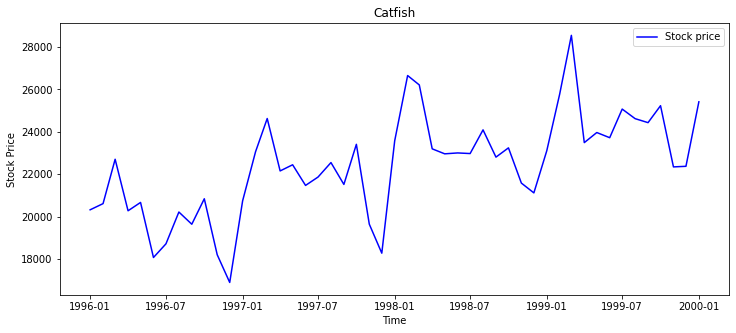

In [19]:
plt.figure(figsize=(12,5))
plt.plot(lim_catfish_sales, color='Blue', label='Stock price')
plt.title('Catfish')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Testing the hypothesis on 5% significance level:

In [13]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(lim_catfish_sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.342716
p-value: 0.158561


as p-value = 0.156 > 0.05, the first difference is needed.

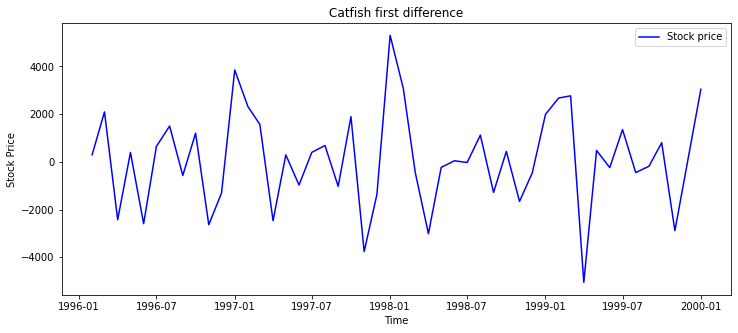

In [21]:
plt.figure(figsize=(12,5))
plt.plot(lim_catfish_sales.diff(), color='Blue', label='Stock price')
plt.title('Catfish first difference')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In order to determine the order p and q graph PACF and ACF functions of first difference

In [41]:
n_lags = 20

<BarContainer object of 20 artists>

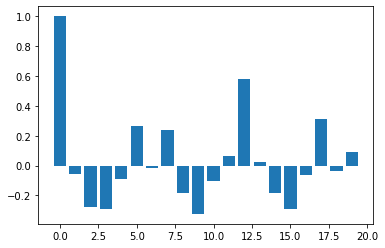

In [42]:
acfv = acf(lim_catfish_sales.diff()[1:])
plt.bar(range(n_lags), acfv[:n_lags])

In [ ]:
pacfv=pacf(lim_catfish_sales.diff()[1:])
plt.bar(range(n_lags), pacfv[:n_lags])

From the PACF and ACF it is clear that we have to use SARIMA(0,1,0)(1,0,1).

Divide the inital data on train and test:

In [46]:
train_data = lim_catfish_sales[:datetime(1999,7,1)]
test_data = lim_catfish_sales[datetime(1999,7,1)+ timedelta(days=1):datetime(2000,1,1)]

Fit our model and predict values:

In [47]:
model_analytical = pm.arima.ARIMA((0, 1, 0), seasonal_order=(1, 0, 1, 12))
model_analytical.fit(train_data)

/Users/kevin/jupyter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/kevin/jupyter/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/kevin/jupyter/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(order=(0, 1, 0), seasonal_order=(1, 0, 1, 12))

In [51]:
predictions_analytical = pd.Series(model_analytical.predict(len(test_data)))


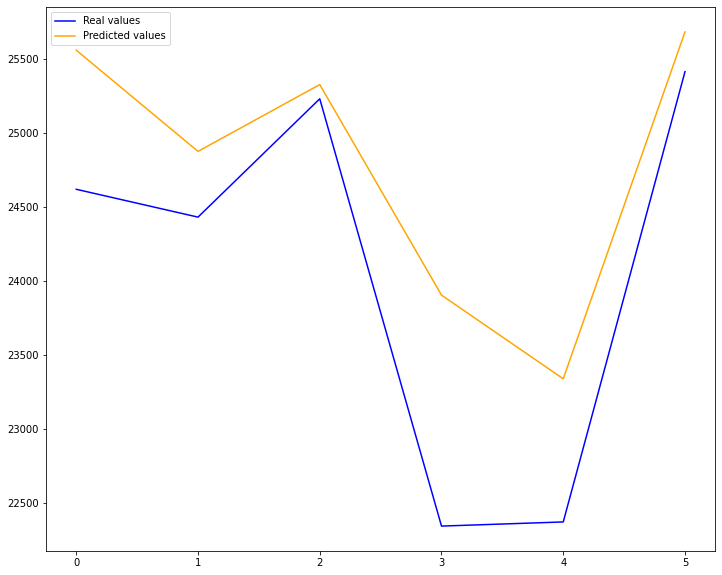

In [55]:
plt.figure(figsize=(12,10))
plt.plot(test_data.reset_index()['Total'], color = 'Blue', label='Real values')
plt.plot(predictions_analytical, color='Orange', label='Predicted values')
plt.legend()
plt.show()

Using non-analytical approach:

In [56]:
model_auto = pm.auto_arima(train_data, start_p=0, start_q=0, start_d = 0, max_p=5, max_d = 5, max_q = 5,
                      m=12,
                      #d=1,
                      seasonal=True,
                      D=0,
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True,
                      stepwise=True,
                      start_P = 0,
                      start_Q = 0,
                      start_D = 0,
                      max_P = 5,
                      max_Q = 5,
                      max_D = 5 )#n_jobs=-1)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=764.593, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=745.025, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=758.323, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=762.725, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=766.589, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=737.036, Time=0.22 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=739.032, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=738.854, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=743.438, Time=0.20 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=736.477, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=743.798, Time=0.11 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=738.493, Time=0.39 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=738.318, Time=0.45 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   

In [58]:
predictions_auto = pd.Series(model_auto.predict(len(test_data)))


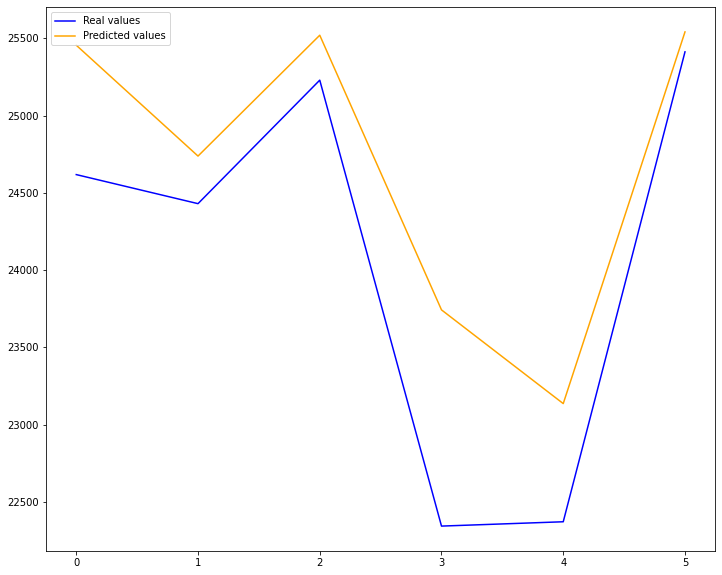

In [59]:
plt.figure(figsize=(12,10))
plt.plot(test_data.reset_index()['Total'], color = 'Blue', label='Real values')
plt.plot(predictions_auto, color='Orange', label='Predicted values')
plt.legend()
plt.show()